# Electricity Production forecast using RNN

## Topic

In this notebook I will experiemnt with a simple RNN to forecast a time series. The time series I chose is electricity production over more then 20 years, with the production recorded on a monthly basis. I will use a simple non stacked RNN, my input will be the current value and output will be the next value to come. So let's get started !

## Objective

- Forecast electricity production using an RNN

## Summary

- Importing libraries
- The data
- Data plotting
- Creating the dataset
- Building the model
- Training the model
- Plotting the forecast

### Importing libraries

In [37]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from scipy import signal
import torch.utils.data as data

### The Dataset

In [2]:
dataset = pd.read_csv(r'C:\Users\imane\Downloads\archive (22)\Electric_Production.csv', sep =",")
dataset

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151
...,...,...
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212


In [3]:
dataset.shape

(397, 2)

In [4]:
dataset = dataset.rename(columns = {"DATE": "date", "IPG2211A2N": "production"})

In [5]:
dataset["date"] = pd.to_datetime(dataset["date"])

In [6]:
dataset.dtypes

date          datetime64[ns]
production           float64
dtype: object

In [7]:
dataset

,date,production
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151
...,...,...
392,2017-09-01,98.6154
393,2017-10-01,93.6137
394,2017-11-01,97.3359
395,2017-12-01,114.7212


The dataset contains monthly recorded electricity production over a course of 20+ years. In this part I just renamed the columns and converted the date column to datetime.

### Data plotting

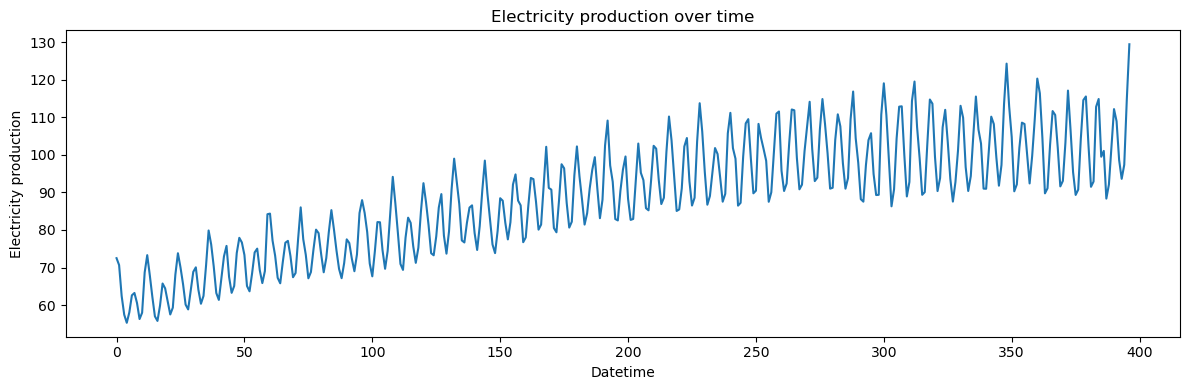

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(dataset['production'])
plt.xlabel('Datetime')
plt.ylabel('Electricity production')
plt.title('Electricity production over time')
plt.tight_layout()
plt.show()

In [9]:
detrended = signal.detrend(dataset.production)
df = pd.DataFrame()
df = df.assign(production = detrended)

In [10]:
data = df[["production"]].values.astype('float32')


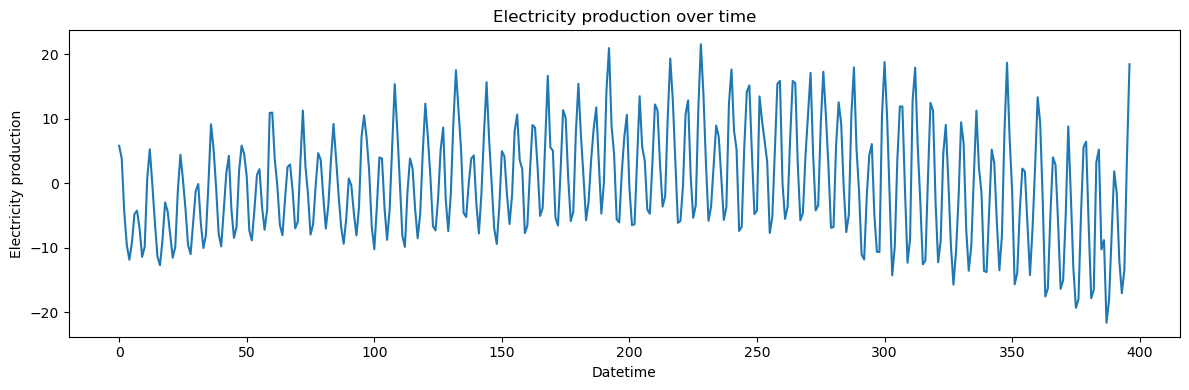

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(df['production'])
plt.xlabel('Datetime')
plt.ylabel('Electricity production')
plt.title('Electricity production over time')
plt.tight_layout()
plt.show()

The data plot show that the timeseries has an upward trend over time, i order to be able to make precise predictions I had to detrend the data using signal. 

In [90]:
len(data)

397

In [29]:
train_size = int(len(df) * 0.72)
test_size = len(df) - train_size
train, test = data[:train_size], data[train_size:]

In [30]:
len(train)

285

Next I split the data into training and testing parts, the first 72% of the data will be for training and the rest for testing.

### Creating the dataset

In [31]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
      
    feature = torch.tensor(X)
    target = torch.tensor(y)
    return feature, target

In [32]:
lookback = 1
X_train, y_train = create_dataset(train, lookback = lookback)
X_test, y_test = create_dataset(test, lookback = lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([284, 1, 1]) torch.Size([284, 1, 1])
torch.Size([111, 1, 1]) torch.Size([111, 1, 1])


C:\Users\imane\AppData\Local\Temp\ipykernel_16296\912132069.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  feature = torch.tensor(X)


In the above I implemented a function that takes a timeseries and a lookback window (because y is  x shifted by 1), seperates the input and target (the input being the current point and the target being the next one), and returns an input tensor and output tensor.

### Building the model

In [33]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        
        out, hidden = self.rnn(x, hidden)
        out = out.view(-1, self.hidden_dim)
        output = self.fc(out)
        
        return output, hidden

In [34]:
input_size = 1
output_size = 1
hidden_dim = 50
n_layers = 1
model = RNN(input_size, output_size, hidden_dim, n_layers)
print(model)

RNN(
  (rnn): RNN(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


So the model I built is a simple RNN with non stacked cells. Its input size is 1 seen as I will feed it one sequence at a time, and the ouput size is 1 accordingly. I chose 50 as the hidden dimension features.

In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.1)

In [39]:
test_out, test_hidden = model(X_train, None)
print(test_out.size())
print(test_hidden.size())

torch.Size([284, 1])
torch.Size([1, 284, 50])


Next I set up the loss criterions which is mean squared error since I'm working with continuous values and tested out the model to make sure the tensor dimensions are correct.

### Training the model

In [40]:
n_epochs = 4000
train_loss , test_loss = [], []
for epoch in range(n_epochs):
    hidden = None
    model.train
    t_loss = 0.0
    for x in range(len(X_train)):
        
        pred, hidden = model(X_train, hidden)
        hidden = hidden.data
        loss = criterion(pred, y_train)
        rmse = np.sqrt(loss.detach().numpy())
        t_loss += rmse
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    
    if epoch% 100 != 0:
        continue
    
    model.eval()
    
    with torch.no_grad():
        #train_p, hidden = model(X_train, hidden)
        #train_rmse = np.sqrt(criterion(train_p, y_train))
        #train_loss.append(train_rmse)
        train_loss.append(t_loss/len(X_train))
        test_p, hidden = model(X_test, None)
        test_rmse = np.sqrt(criterion(test_p, y_test))
        test_loss.append(test_rmse)
        print("epoch", epoch, "train rmse", t_loss/len(X_train), "test rmse", test_rmse)

C:\Users\imane\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([284, 1, 1])) that is different to the input size (torch.Size([284, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\imane\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([111, 1, 1])) that is different to the input size (torch.Size([111, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0 train rmse 7.553137834642975 test rmse tensor(10.9383)
epoch 100 train rmse 7.550691854785866 test rmse tensor(11.0243)
epoch 200 train rmse 7.551976937643239 test rmse tensor(11.1115)
epoch 300 train rmse 7.552233291343904 test rmse tensor(11.1240)
epoch 400 train rmse 7.552212609371669 test rmse tensor(11.1230)
epoch 500 train rmse 7.5523080120623955 test rmse tensor(11.1234)
epoch 600 train rmse 7.552208141541817 test rmse tensor(11.1179)
epoch 700 train rmse 7.552270765035924 test rmse tensor(11.1231)
epoch 800 train rmse 7.552035046295381 test rmse tensor(11.1232)
epoch 900 train rmse 7.5522444718320605 test rmse tensor(11.1392)
epoch 1000 train rmse 7.552012393172358 test rmse tensor(11.1272)
epoch 1100 train rmse 7.552250615307982 test rmse tensor(11.1227)
epoch 1200 train rmse 7.552346110343933 test rmse tensor(11.1222)
epoch 1300 train rmse 7.552196791474248 test rmse tensor(11.1171)
epoch 1400 train rmse 7.552238796798276 test rmse tensor(11.1164)
epoch 1500 train rms

The training went over 4000 epochs and I printed the train and test errors every 100 epochs. Through the training the error didn't improve much and I beleive it's because the RNN only has short term memory that didn't line up well with the highs and lows of the data. 

### Plotting the forecast

In [41]:
def plot_forecast(forecast, model):
    plt.figure(figsize=(12,4))
    #plt.plot(X_train.squeeze(-1), label='Training')
    plt.plot(X_test.squeeze(-1), label='Actual')
    plt.plot(forecast, label='Forecast')
    plt.xlabel('Datetime')
    plt.ylabel('electricity production')
    plt.legend()
    plt.tight_layout()
    plt.show()

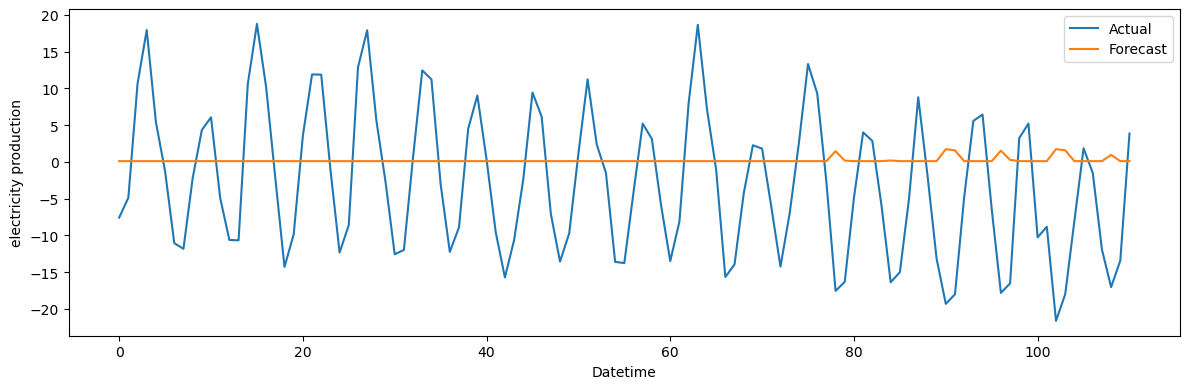

In [42]:
forecast, hidden = model(X_test, None)
plot_forecast(forecast.detach().numpy(), "Simple RNN")

The graph shows the actual values of the testing set in blue and the network's output in orange don't line up, it seems as though the network finds the average between the highs and lows of the data. Seen as RNNs only work with short term memory, it seems that an LSTM would work better on this dataset. That's what I'll try next.